# Análisis de series temporales

## Descarga de un conjunto de datos

El conjunto de datos en cuestión contiene información sobre los valores de las acciones _(stock)_ de la empresa de venta de videojuegos [GameStop](https://es.wikipedia.org/wiki/GameStop). Esta información ha sido recopilada desde el año 2002 hasta enero de 2021, estando referenciada la fecha exacta de cada registro en el conjunto de datos.

Este conjunto de datos ha sido extraído del siguiente _post_ de [Kaggle](https://www.kaggle.com/datasets/hananxx/gamestop-historical-stock-prices), un repositorio público de conjuntos de datos.

### Lectura de datos

In [1]:
import pandas as pd

df = pd.read_csv('../data/input/GME_stock.csv', index_col='date', parse_dates=True).iloc[::-1]

In [2]:
display(df)

,open_price,high_price,low_price,close_price,volume,adjclose_price
date,,,,,,
2002-02-13,9.625000,10.060000,9.525000,10.050000,19054000.0,6.766666
2002-02-14,10.175000,10.195000,9.925000,10.000000,2755400.0,6.733003
2002-02-15,10.000000,10.025000,9.850000,9.950000,2097400.0,6.699336
2002-02-19,9.900000,9.900000,9.375000,9.550000,1852600.0,6.430017
2002-02-20,9.600000,9.875000,9.525000,9.875000,1723200.0,6.648838
...,...,...,...,...,...,...
2021-01-22,42.590000,76.760002,42.320000,65.010002,196784300.0,65.010002
2021-01-25,96.730003,159.179993,61.130001,76.790001,177874000.0,76.790001
2021-01-26,88.559998,150.000000,80.199997,147.979996,178588000.0,147.979996


### Rellenado de días faltantes

In [3]:
min_date = df.index.min()
max_date = df.index.max()

full_date_range = pd.date_range(
    start=min_date,
    end=max_date
)

df = df.reindex(full_date_range)

display(df)

,open_price,high_price,low_price,close_price,volume,adjclose_price
2002-02-13,9.625000,10.060000,9.525000,10.050000,19054000.0,6.766666
2002-02-14,10.175000,10.195000,9.925000,10.000000,2755400.0,6.733003
2002-02-15,10.000000,10.025000,9.850000,9.950000,2097400.0,6.699336
2002-02-16,NaN,NaN,NaN,NaN,NaN,NaN
2002-02-17,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2021-01-24,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-25,96.730003,159.179993,61.130001,76.790001,177874000.0,76.790001
2021-01-26,88.559998,150.000000,80.199997,147.979996,178588000.0,147.979996
2021-01-27,354.829987,380.000000,249.000000,347.510010,93396700.0,347.510010


### Interpolación de valores faltantes

In [4]:
df = df.interpolate(method='linear')

display(df)

,open_price,high_price,low_price,close_price,volume,adjclose_price
2002-02-13,9.625000,10.060000,9.525000,10.050000,1.905400e+07,6.766666
2002-02-14,10.175000,10.195000,9.925000,10.000000,2.755400e+06,6.733003
2002-02-15,10.000000,10.025000,9.850000,9.950000,2.097400e+06,6.699336
2002-02-16,9.975000,9.993750,9.731250,9.850000,2.036200e+06,6.632006
2002-02-17,9.950000,9.962500,9.612500,9.750000,1.975000e+06,6.564676
...,...,...,...,...,...,...
2021-01-24,78.683336,131.706662,54.860001,72.863335,1.841774e+08,72.863335
2021-01-25,96.730003,159.179993,61.130001,76.790001,1.778740e+08,76.790001
2021-01-26,88.559998,150.000000,80.199997,147.979996,1.785880e+08,147.979996
2021-01-27,354.829987,380.000000,249.000000,347.510010,9.339670e+07,347.510010


### Eliminado de fechas extremas

In [5]:
df = df[df.index <= pd.to_datetime('2020-10-31')]

display(df)

,open_price,high_price,low_price,close_price,volume,adjclose_price
2002-02-13,9.625000,10.060000,9.525000,10.050000,1.905400e+07,6.766666
2002-02-14,10.175000,10.195000,9.925000,10.000000,2.755400e+06,6.733003
2002-02-15,10.000000,10.025000,9.850000,9.950000,2.097400e+06,6.699336
2002-02-16,9.975000,9.993750,9.731250,9.850000,2.036200e+06,6.632006
2002-02-17,9.950000,9.962500,9.612500,9.750000,1.975000e+06,6.564676
...,...,...,...,...,...,...
2020-10-27,13.710000,13.710000,12.360000,12.690000,7.231000e+06,12.690000
2020-10-28,12.270000,13.050000,11.780000,11.820000,6.388600e+06,11.820000
2020-10-29,11.880000,12.250000,11.680000,11.730000,4.165800e+06,11.730000
2020-10-30,11.640000,11.640000,10.360000,10.470000,1.154690e+07,10.470000


## Descripción (cuantitativa) del conjunto de datos y su origen

El conjunto de datos tiene las siguientes características:

| Característica | Descripción |
|-|-|
|`date`|Variable temporal que indica el día de registro de los datos|
|`open_price`|Precio inicial del _stock_ al inicio del día|
|`high_price`|Precio más alto del _stock_ a lo largo del día|
|`low_price`|Precio más bajo del _stock_ a lo largo del día|
|`close_price`|Precio del _stock_ al final del día|
|`volume`|Número de acciones intercambiadas durante el día|
|`adjclose_price`|Precio final del _stock_ ajustado a distribuciones o acciones comerciales ocurridas antes del siguiente día financiero|

## Análisis temporal de los datos

### Precio de inicio

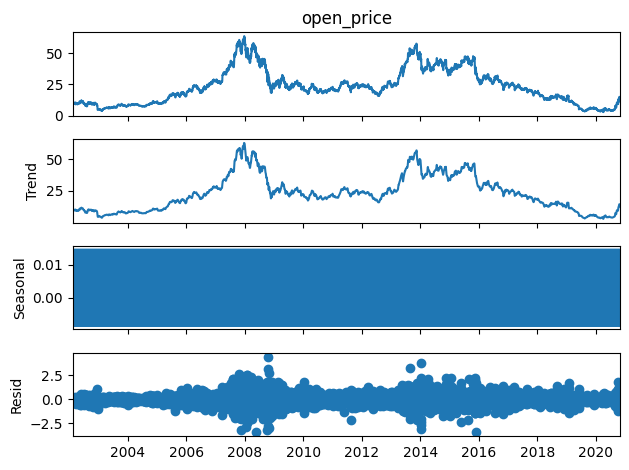

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

seasonal_decompose(df['open_price'], model='additive').plot(); None

### Precio más alto

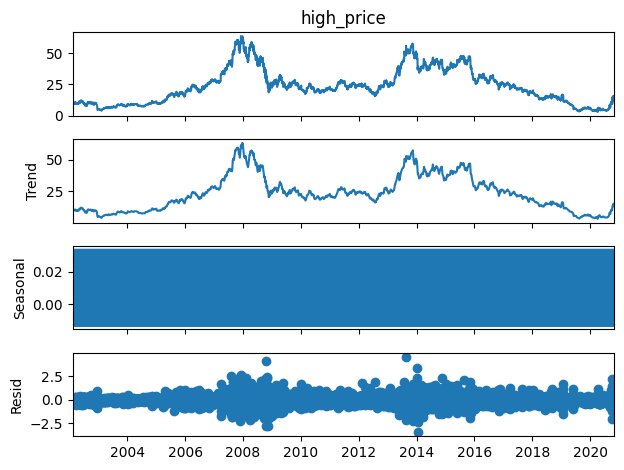

In [7]:
seasonal_decompose(df['high_price'], model='additive').plot(); None

### Precio más bajo

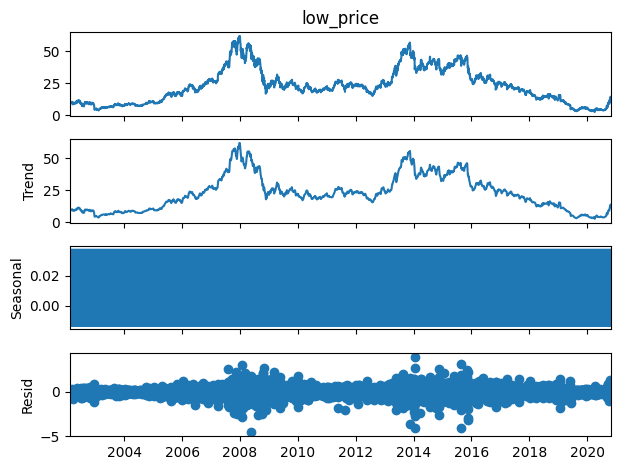

In [8]:
seasonal_decompose(df['low_price'], model='additive').plot(); None

### Precio de cierre

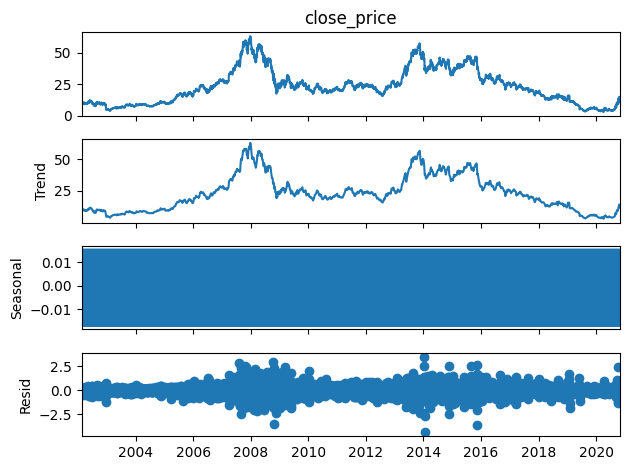

In [9]:
seasonal_decompose(df['close_price'], model='additive').plot(); None

### Precio de cierre ajustado

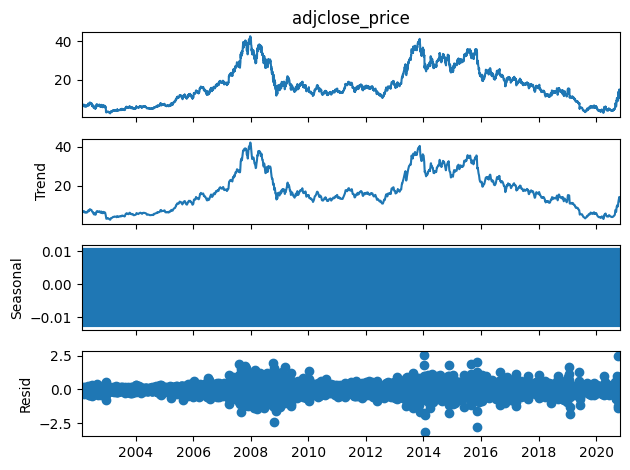

In [10]:
seasonal_decompose(df['adjclose_price'], model='additive').plot(); None

## Aplicación de modelos de predicción

In [11]:
import matplotlib.pyplot as plt

### Modelo Baseline

In [12]:
# Media Movil Exponencial

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import r2_score
import warnings

model_results = {}

TEST_SIZE = 10

for column in df.columns:
    subset = df[column]

    train_data = subset.iloc[:-TEST_SIZE]
    test_data = subset.iloc[-TEST_SIZE - 1:]

    model = ExponentialSmoothing(train_data)

    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        model = model.fit()

    predictions = model.predict(
        start = test_data.index[0],
        end = test_data.index[-1]
    )

    score = r2_score(test_data, predictions)
    model_results[column] = score

In [13]:
pd.DataFrame.from_dict(
    data = model_results, 
    orient = 'index',
    columns = ['R2 score']
)

,R2 score
open_price,-0.066875
high_price,-0.070989
low_price,-0.535748
close_price,-0.469288
volume,-0.589755
adjclose_price,-0.469288


### Modelo _ARIMA_

In [33]:
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import r2_score

TEST_SIZE = 10

results = {}

for column in df.columns:

    subset = df[column]

    train_data = subset.iloc[:-TEST_SIZE]
    test_data = subset.iloc[-TEST_SIZE - 1:]

    order_analysis = auto_arima(
        y = train_data,
        max_p = 3,
        max_d = 2,
        max_q = 3
    )
    
    model = ARIMA(train_data, order=order_analysis.order)
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        arima_results = model.fit()
    y_pred = arima_results.predict(
        start = test_data.index[0],
        end = test_data.index[-1]
    )

    score = r2_score(test_data, y_pred)

    results[column] = score

pd.DataFrame.from_dict(
    data = results,
    orient = 'index',
    columns = ['r2_score']
)

,0
open_price,-0.072313
high_price,-0.075388
low_price,-0.540521
close_price,-0.469288
volume,-1.167959
adjclose_price,-0.509137


### Modelo _Prophet_

In [17]:
from prophet import Prophet
from sklearn.metrics import r2_score

TEST_SIZE = 10

results = {}

for column in df.columns:
    subset = df.reset_index(names='ds')[['ds', column]]
    subset.columns = ['ds', 'y']

    train_data = subset.iloc[:-TEST_SIZE]
    test_data = subset.iloc[-TEST_SIZE - 1:]

    model = Prophet().fit(train_data)

    prediction = model.predict(test_data)

    score = r2_score(test_data['y'], prediction['yhat'])
    results[column] = score

pd.DataFrame.from_dict(
    data = results,
    orient = 'index',
    columns = ['r2_score']
)

17:26:11 - cmdstanpy - INFO - Chain [1] start processing
17:26:23 - cmdstanpy - INFO - Chain [1] done processing
17:26:24 - cmdstanpy - INFO - Chain [1] start processing
17:26:34 - cmdstanpy - INFO - Chain [1] done processing
17:26:34 - cmdstanpy - INFO - Chain [1] start processing
17:26:44 - cmdstanpy - INFO - Chain [1] done processing
17:26:45 - cmdstanpy - INFO - Chain [1] start processing
17:26:56 - cmdstanpy - INFO - Chain [1] done processing
17:26:57 - cmdstanpy - INFO - Chain [1] start processing
17:27:00 - cmdstanpy - INFO - Chain [1] done processing
17:27:02 - cmdstanpy - INFO - Chain [1] start processing
17:27:14 - cmdstanpy - INFO - Chain [1] done processing


,r2_score
open_price,-53.172934
high_price,-43.048658
low_price,-44.840598
close_price,-37.492690
volume,-0.760976
adjclose_price,-31.985669
